In [20]:
import torch
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# 加载特征
feats_list = torch.load('logs/dinov2_backbone_dinov2_large/feats_list.pth')
feats_num = len(feats_list)
print(feats_num)

print(len(feats_list[0]))

steps=[10, 100, 1000]

all_feats_change = []
for j in range(len(feats_list[0])): # 遍历每个特征
    feats_change = []
    for step in steps:
        tmp_feats_change = []
        for i in range(0,feats_num-step):
            current_feats = feats_list[i][j]
            next_feats = feats_list[i+step][j]
            # 计算特征变化, 使用欧氏距离
            distance = torch.norm(current_feats - next_feats, p=2)
            tmp_feats_change.append(distance)
        feats_change.append(tmp_feats_change)
    all_feats_change.append(feats_change)  

29310
4


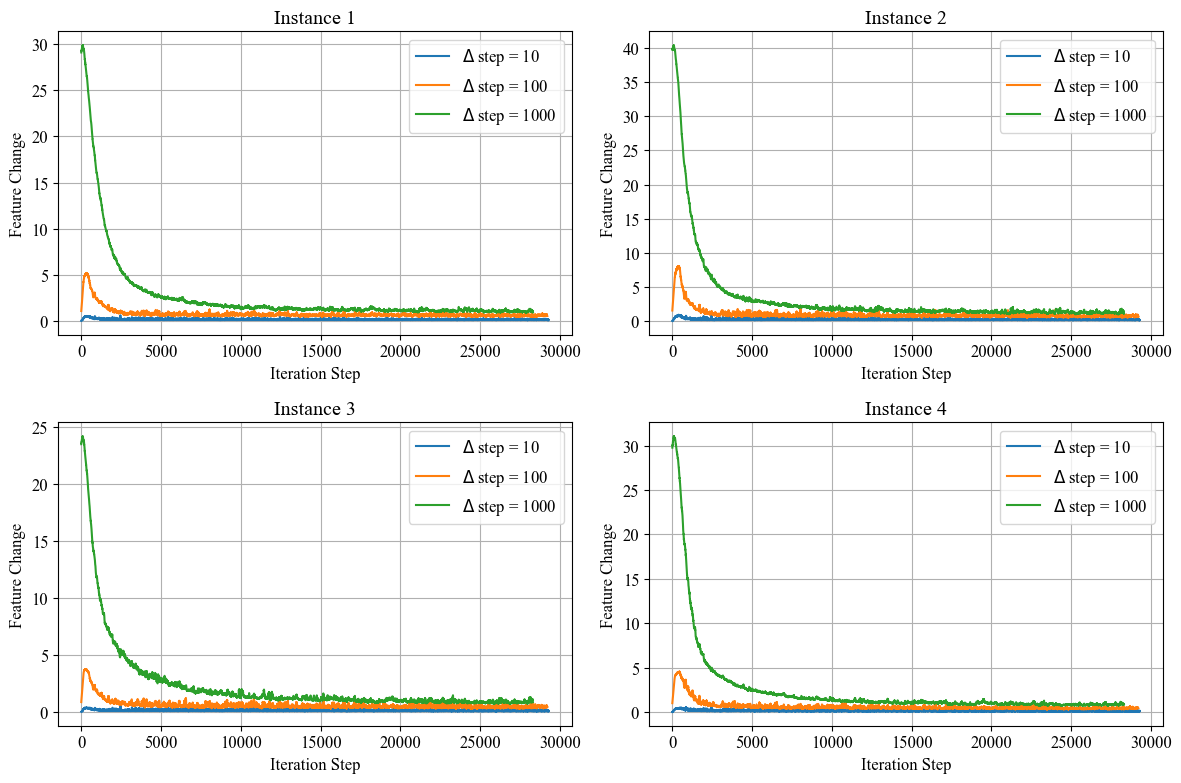

In [32]:
# 遍历每个特征，将不同step的特征变化绘制在一张图上
# 创建一个figure，将all_feats_change中的四个元素绘制在一张图的子图上，两行两列  

# 设置全局字体和大小
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# 创建一个2x2的子图布局
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# fig.suptitle('Feature Change Trend', fontsize=16)

# 遍历每个特征
for idx, feats_change in enumerate(all_feats_change):
    row = idx // 2
    col = idx % 2
    for i in range(len(feats_change)):
        change=feats_change[i]
        # 绘制不同step的特征变化
        axs[row, col].plot(change, label=f'$\Delta$ step = {steps[i]}')
    
    axs[row, col].set_title(f'Instance {idx+1}')
    axs[row, col].set_xlabel('Iteration Step')
    axs[row, col].set_ylabel('Feature Change')
    axs[row, col].legend()
    axs[row, col].grid(True)
plt.tight_layout()
plt.savefig('some_result_images/feats_change/feats_change.png', dpi=600, bbox_inches='tight')
plt.show()


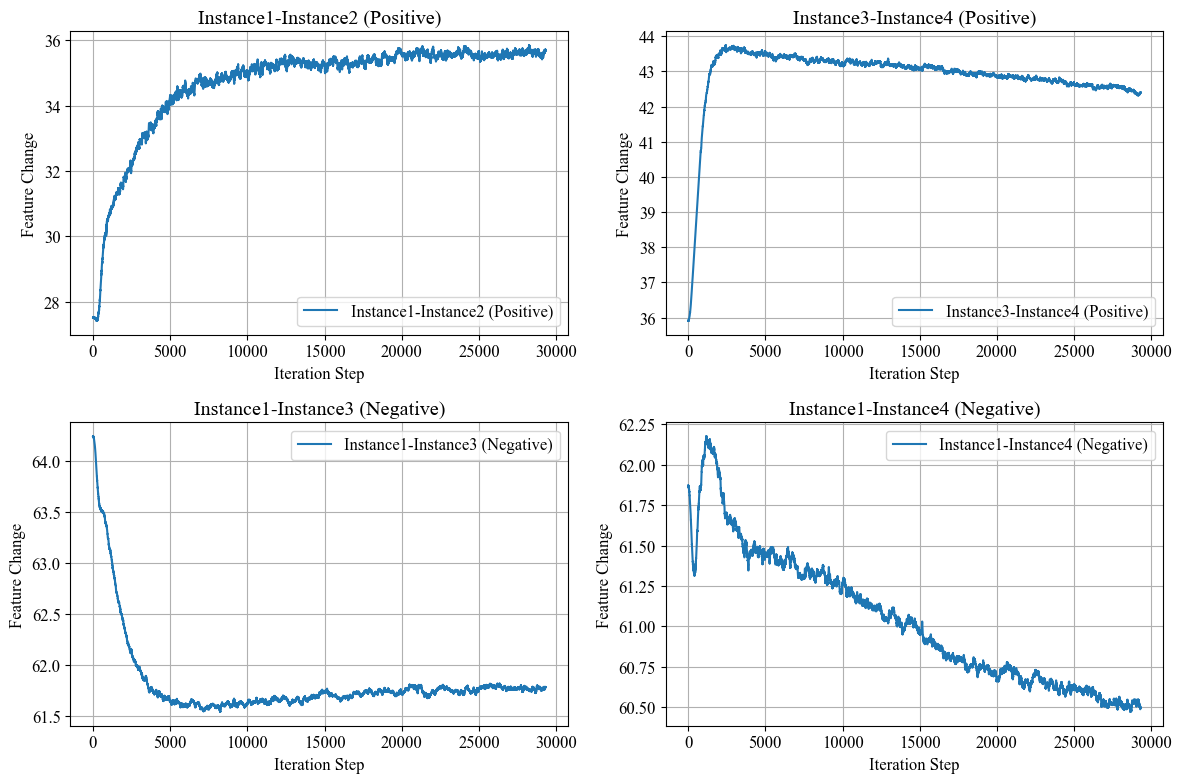

In [40]:
instance1, instance2, instance3, instance4 = [], [], [], []
for i in range(len(feats_list)):
    instance1.append(feats_list[i][0])
    instance2.append(feats_list[i][1])
    instance3.append(feats_list[i][2])
    instance4.append(feats_list[i][3])

# 计算instance1和instance2的欧氏距离
instance1_instance2_distance = []
for i in range(len(instance1)):
    distance = torch.norm(instance1[i] - instance2[i], p=2)
    instance1_instance2_distance.append(distance)

# 计算instance3和instance4的欧氏距离
instance3_instance4_distance = []
for i in range(len(instance3)):
    distance = torch.norm(instance3[i] - instance4[i], p=2)
    instance3_instance4_distance.append(distance)

# 计算instance1和instance3的欧氏距离
instance1_instance3_distance = []
for i in range(len(instance1)):
    distance = torch.norm(instance1[i] - instance3[i], p=2)
    instance1_instance3_distance.append(distance)

# 计算instance1和instance4的欧氏距离
instance1_instance4_distance = []
for i in range(len(instance1)):
    distance = torch.norm(instance1[i] - instance4[i], p=2)
    instance1_instance4_distance.append(distance)


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(instance1_instance2_distance, label=f'Instance1-Instance2 (Positive)')
axs[0, 0].set_title(f'Instance1-Instance2 (Positive)')
axs[0, 0].set_xlabel('Iteration Step')
axs[0, 0].set_ylabel('Feature Change')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(instance3_instance4_distance, label=f'Instance3-Instance4 (Positive)')
axs[0, 1].set_title(f'Instance3-Instance4 (Positive)')
axs[0, 1].set_xlabel('Iteration Step')
axs[0, 1].set_ylabel('Feature Change')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(instance1_instance3_distance, label=f'Instance1-Instance3 (Negative)')
axs[1, 0].set_title(f'Instance1-Instance3 (Negative)')
axs[1, 0].set_xlabel('Iteration Step')
axs[1, 0].set_ylabel('Feature Change')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(instance1_instance4_distance, label=f'Instance1-Instance4 (Negative)')
axs[1, 1].set_title(f'Instance1-Instance4 (Negative)')
axs[1, 1].set_xlabel('Iteration Step')
axs[1, 1].set_ylabel('Feature Change')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()

plt.savefig('some_result_images/feats_change/feats_change_instance.png', dpi=600, bbox_inches='tight')
plt.show()